# 1.Импорт модулей

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional
from torchsummary import summary

# метрика качества 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 2.Загрузка датасета с каггл по апи

In [6]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [3]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/animal-faces

 98% 681M/696M [00:03<00:00, 158MB/s]
100% 696M/696M [00:03<00:00, 211MB/s]


In [5]:
!unzip animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

# 3.Подготовка картинок

Трансформации

In [6]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
        #  transforms.AutoAugment(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])
# отдельный для теста
transform_val = transforms.Compose([
         transforms.Resize((224, 224)),                           
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [7]:
# при загрузке сразу указываем как предобрабатывать
train_data = datasets.ImageFolder('/content/afhq/train', transform=transform_train)
test_data = datasets.ImageFolder('/content/afhq/train', transform=transform_val)

In [8]:
train_data

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: /content/afhq/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
# разбиваем сразу на батчи (обычно берут под максимум, который влезает в память)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1024, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle = True, pin_memory=True, num_workers=2)

In [10]:
# батч картинок и батч ответов к картинкам
images, labels  = next(iter(train_loader))

In [11]:
# размер датасета
images.shape, labels.shape

(torch.Size([1024, 3, 224, 224]), torch.Size([1024]))

In [12]:
train_loader.dataset.classes # классы наши

['cat', 'dog', 'wild']

In [13]:
labels

tensor([1, 0, 1,  ..., 2, 2, 2])

Отобразим несколько картинок

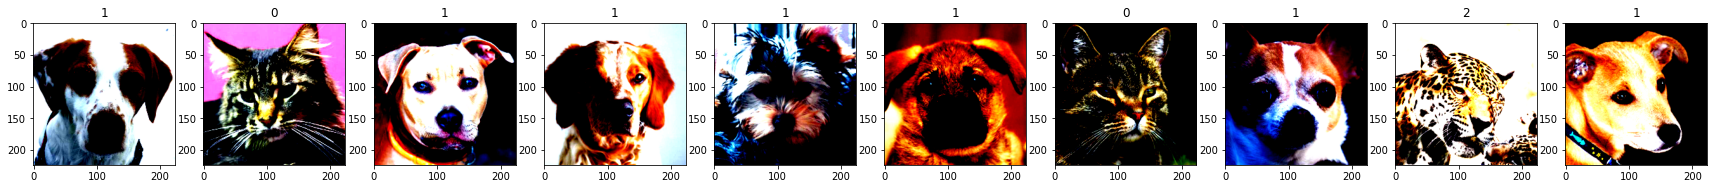

In [14]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        # загружаем изображения как тип ndarray (Height * Width * Channels)
        # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
        # в этом примере я не использую метод ToTensor() из torchvision.transforms
        # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
        # axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray') # можно было без сквиза
        axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

# 4.Подготовка модели

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
images[0].shape # размер на вход линейного слоя 3 * 224 * 224

torch.Size([3, 224, 224])

In [17]:
in_features = 3*224*224
out_features = 256
classes = 3

In [18]:
model = nn.Sequential(
    
    nn.Flatten(),
    # 1 скрытый слой
    nn.Linear(in_features, out_features),
    nn.ReLU(),
    # 2 скрытый слой
    nn.Linear(out_features, out_features),
    nn.ReLU(),
    # выходной слой
    nn.Linear(out_features, classes)
)

# перенос на ГПУ при возможности
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=3, bias=True)
)

In [19]:
summary(model, (3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 150528]               0
            Linear-2                  [-1, 256]      38,535,424
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 3]             771
Total params: 38,601,987
Trainable params: 38,601,987
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 1.16
Params size (MB): 147.25
Estimated Total Size (MB): 148.99
----------------------------------------------------------------


In [20]:
#лосс
criterion = nn.CrossEntropyLoss()

#оптимизатор
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

# 5.Обучение модели

In [21]:
epochs = 10

losses = []
# accuracy_train_epoch = []

print(f'началось обучение')

for epoch in tqdm(range(epochs)):

  print(f'эпоха {epoch}')

  # тренируемся
  for x_batch, y_batch in tqdm(train_loader):
    # accuracy_batches = []
    y_pred_train = np.array([])
    y_real_train = np.array([])

    # 1. # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    #0. перевод в тренировочный режим нашей модели
    model.train()

    # 0.1 Обнуление градиентов
    optimizer.zero_grad()

    # 2. вычисляем скор с помощью прямого распространения
    outp = model(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
    loss = criterion(outp, y_batch)
    losses.append(loss.item())

    # 4. вычисляем градиенты
    loss.backward()

    # 5. шаг градиентного спуска
    optimizer.step()

    # индекс макс эл-та есть предикт
    y_pred_batch = outp.argmax(-1) 

    # # accuracy на батче
    # accuracy_batch = accuracy_score(y_batch.cpu().numpy(), y_pred_batch.cpu().numpy())
    # accuracy_batches.append(accuracy_batch)
    
    # собираю в один массив ответы по батчу и предсказания по батчу
    y_pred_train = np.append(y_pred_train, y_pred_batch.cpu().numpy())
    y_real_train = np.append(y_real_train, y_batch.cpu().numpy())

  # # усредняем accuracy всех батчей
  # accuracy_train_epoch.append(np.mean(np.array(accuracy_batches)))

  print(classification_report(y_real_train, y_pred_train))

print('обучение закончено')

началось обучение


  0%|          | 0/10 [00:00<?, ?it/s]

эпоха 0


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       122
         1.0       0.73      0.66      0.69       104
         2.0       0.55      0.69      0.61        68

    accuracy                           0.70       294
   macro avg       0.69      0.69      0.69       294
weighted avg       0.71      0.70      0.70       294

эпоха 1


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       106
         1.0       0.74      0.67      0.70        85
         2.0       0.79      0.75      0.77       103

    accuracy                           0.76       294
   macro avg       0.76      0.75      0.75       294
weighted avg       0.76      0.76      0.76       294

эпоха 2


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        85
         1.0       0.73      0.86      0.79       101
         2.0       0.93      0.70      0.80       108

    accuracy                           0.81       294
   macro avg       0.82      0.82      0.81       294
weighted avg       0.82      0.81      0.81       294

эпоха 3


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        85
         1.0       0.90      0.86      0.88       111
         2.0       0.91      0.87      0.89        98

    accuracy                           0.87       294
   macro avg       0.87      0.87      0.87       294
weighted avg       0.87      0.87      0.87       294

эпоха 4


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92        98
         1.0       0.89      0.94      0.92        98
         2.0       0.94      0.86      0.90        98

    accuracy                           0.91       294
   macro avg       0.91      0.91      0.91       294
weighted avg       0.91      0.91      0.91       294

эпоха 5


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       110
         1.0       0.93      0.97      0.95        90
         2.0       0.96      0.93      0.94        94

    accuracy                           0.95       294
   macro avg       0.95      0.95      0.95       294
weighted avg       0.95      0.95      0.95       294

эпоха 6


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       105
         1.0       0.95      1.00      0.97        89
         2.0       1.00      0.94      0.97       100

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294

эпоха 7


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        97
         1.0       1.00      0.98      0.99        91
         2.0       1.00      0.98      0.99       106

    accuracy                           0.99       294
   macro avg       0.99      0.99      0.99       294
weighted avg       0.99      0.99      0.99       294

эпоха 8


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       118
         1.0       0.97      0.99      0.98        95
         2.0       0.99      0.99      0.99        81

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294

эпоха 9


  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        87
         1.0       0.99      1.00      1.00       104
         2.0       0.99      0.98      0.99       103

    accuracy                           0.99       294
   macro avg       0.99      0.99      0.99       294
weighted avg       0.99      0.99      0.99       294

обучение закончено


График лосса в первом приближении

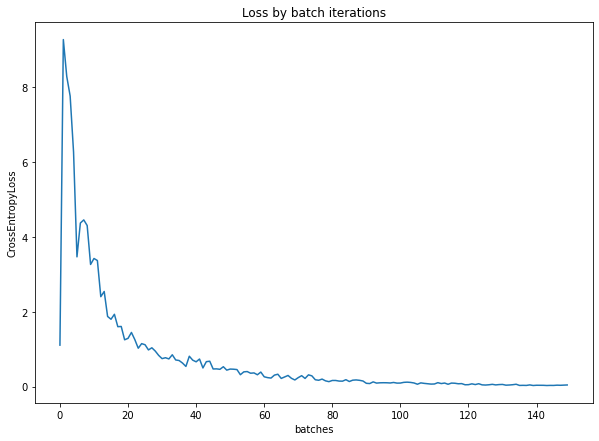

In [22]:
plt.figure(figsize=(10, 7))

plt.plot(losses)

plt.title('Loss by batch iterations')
plt.ylabel('CrossEntropyLoss')
plt.xlabel('batches')

plt.show()

График лосса на последниз 100 значений

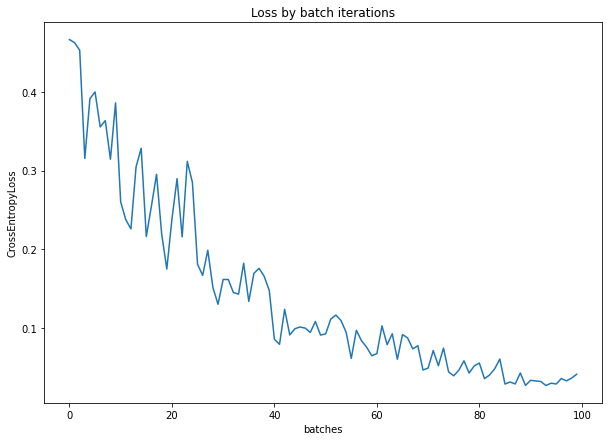

In [24]:
plt.figure(figsize=(10, 7))

plt.plot(losses[-100:])

plt.title('Loss by batch iterations')
plt.ylabel('CrossEntropyLoss')
plt.xlabel('batches')

plt.show()

# 6.Прогон на тесте

In [25]:
# accuracy_test_epoch = []

# замеряем метрику на тестовых батчах
for x_batch, y_batch in tqdm(test_loader):
  # accuracy_batches = []
  y_pred_test = np.array([])
  y_real_test = np.array([])

  # 1. # загружаем батч данных (вытянутый в линию)
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)

  #0. перевод в тренировочный режим нашей модели
  model.eval()

  # 2. вычисляем скор с помощью прямого распространения
  outp = model(x_batch)

  # индекс макс эл-та есть предикт
  y_pred_batch = outp.argmax(-1) # принтануть, или np.argmax(y_pred.detach().numpy(), axis=1) тест 

  # # accuracy на батче
  # accuracy_batch = accuracy_score(y_batch.cpu().numpy(), y_pred_batch.cpu().numpy())
  # accuracy_batches.append(accuracy_batch)

  y_pred_test = np.append(y_pred_test, y_pred_batch.cpu().numpy())
  y_real_test = np.append(y_real_test, y_batch.cpu().numpy())

# # усредняем accuracy всех батчей
# accuracy_test_epoch.append(np.mean(np.array(accuracy_batches)))

print(classification_report(y_real_test, y_pred_test))

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       103
         1.0       1.00      0.98      0.99       107
         2.0       1.00      1.00      1.00        84

    accuracy                           0.99       294
   macro avg       0.99      0.99      0.99       294
weighted avg       0.99      0.99      0.99       294



In [26]:
model.state_dict() # параметры получившейся модели

OrderedDict([('1.weight',
              tensor([[-2.8954e-03, -4.0536e-03, -3.2187e-03,  ..., -8.2134e-03,
                       -8.3170e-03, -5.8272e-03],
                      [ 2.7629e-03,  4.4085e-03,  4.8925e-03,  ...,  3.4830e-03,
                        8.2158e-03,  7.2965e-03],
                      [ 6.6912e-05,  4.0571e-04, -3.1294e-03,  ...,  2.6779e-03,
                        2.5866e-03, -4.0454e-04],
                      ...,
                      [ 3.8863e-03, -3.8908e-04, -1.8610e-04,  ..., -5.0326e-03,
                       -3.6164e-03, -3.5602e-03],
                      [-4.9038e-03, -7.9854e-03, -3.2774e-03,  ...,  1.6849e-03,
                        1.1985e-03, -1.2262e-03],
                      [ 2.1512e-04,  1.8108e-04,  2.2612e-03,  ...,  2.5083e-03,
                       -6.4200e-04,  2.9135e-03]], device='cuda:0')),
             ('1.bias',
              tensor([-1.5569e-03, -7.0465e-03, -1.3559e-02,  3.0265e-03, -1.6094e-02,
                      -6.0876e

Сохраню модель

In [28]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/MIPT ФПМИ DS/3.ML/ДЗ/ДЗ_5/best_model.pt')

In [ ]:
# загрузка лучшей модели после
# model = mymodel()
# model.load_state_dict(torch.load('./best_model.pt'))
# model.eval()